
# CoNi 16 Dataset Cropping

### Indices of the BSE crop:

***Original shape: $(2048, 3072)$***

    - X (columns)
        - Total crop width: dx = 2220 
        - slice(476, 2696)
    - Y (rows)
        - Total crop height: dy = 1665
        - slice(175, 1840)

Once this crop is complete, a resize transform was applied through ***scikit-image*** to get to a target size of $(483, 644)$

### Indices of the EBSD crop:

***Original shape: $(484,654)$***

    - X (columns)
        - Total crop width: dx = 644
        - slice(10, None)
    - Y (rows)
        - Total crop height: dy = 483
        - slice(None, -1)


___
___

# Spalled AM Ta Dataset Cropping

### Indices of the BSE crop:

***Original shape: $(4092, 6144)$***

    - X (columns)
        - Total crop width: dx = 4212
        - slice(1066, 5278)
    - Y (rows)
        - Total crop height: dy = 4050
        - slice(0, 4050)

Once this crop is complete, a resize transform was applied through ***scikit-image*** to get to a target size of $(675, 702)$

### Indices of the EBSD crop:

***Original shape: $(689,709)$***

    - X (columns)
        - Total crop width: dx = 702
        - slice(7, None)
    - Y (rows)
        - Total crop height: dy = 675
        - slice(None, 675)


___
___

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
import h5py
from skimage import io, transform, exposure, morphology, measure
from rich.progress import track
%matplotlib widget

import core

def generate_gif(array, savename):
    fig = plt.figure()
    im = plt.imshow(array[0, :, :],
                    animated=True,
                    cmap='cividis',
                    vmin=array.min(),
                    vmax=array.max())
    def init():
        im.set_data(array[0, :, :])
        return im,
    def animate(i):
        im.set_array(array[i, :, :])
        return im,
    anim = ani.FuncAnimation(fig,
                             animate,
                             init_func=init,
                             frames=array.shape[0],
                             interval=1,
                             blit=True)
    anim.save(f"{savename}.gif")
    plt.close()


def get_slice(dx, dy):
    # get slice for x axis
    if dx > 0:
        sliceROW_c = slice(0, -dx, None)
        sliceROW_p = slice(dx, None, None)
    elif dx == 0:
        sliceROW_c = slice(None, None, None)
        sliceROW_p = slice(None, None, None)
    else:
        sliceROW_c = slice(-dx, None, None)
        sliceROW_p = slice(0, dx, None)
    # get slice for y axis
    if dy > 0:
        sliceCOL_c = slice(0, -dy, None)
        sliceCOL_p = slice(dy, None, None)
    elif dy == 0:
        sliceCOL_c = slice(None, None, None)
        sliceCOL_p = slice(None, None, None)
    else:
        sliceCOL_c = slice(-dy, None, None)
        sliceCOL_p = slice(0, dy, None)
    # combine x and y slices and return
    current = (
        sliceROW_c,
        sliceCOL_c,
    )
    previous = (
        sliceROW_p,
        sliceCOL_p,
    )
    return (current, previous)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [19]:
def get_difference(bse, ebsd, x, y):
    if type(x) == tuple:
        ebsd_x = x[0]
        bse_x = x[1]
    else:
        ebsd_x = x
        bse_x = x
    if type(y) == tuple:
        ebsd_y = y[0]
        bse_y = y[1]
    else:
        ebsd_y = y
        bse_y = y
    bse_row_slice = bse[:, bse_y, :]
    bse_col_slice = bse[:, :, bse_x]
    bse_row_slice = morphology.remove_small_holes(bse_row_slice, area_threshold=10000)
    bse_row_slice = morphology.binary_closing(bse_row_slice)[:, :200]
    bse_col_slice = morphology.remove_small_holes(bse_col_slice, area_threshold=10000)
    bse_col_slice = morphology.binary_closing(bse_col_slice)[:, :200]
    bse_locs = np.array(list(zip(bse_row_slice.argmax(axis=1), bse_col_slice.argmax(axis=1))))

    ebsd_row_slice = ebsd[:, ebsd_y, :]
    ebsd_col_slice = ebsd[:, :, ebsd_x]
    ebsd_row_slice = morphology.remove_small_holes(ebsd_row_slice, area_threshold=10000)
    ebsd_row_slice = morphology.binary_closing(ebsd_row_slice)[:, :200]
    ebsd_col_slice = morphology.remove_small_holes(ebsd_col_slice, area_threshold=10000)
    ebsd_col_slice = morphology.binary_closing(ebsd_col_slice)[:, :200]
    ebsd_locs = np.array(list(zip(ebsd_row_slice.argmax(axis=1), ebsd_col_slice.argmax(axis=1))))

    diff = bse_locs - ebsd_locs
    return diff

def apply_shifts(shifts, array):
    new_array = np.zeros(array.shape, dtype=array.dtype)
    for i in range(array.shape[0]):
        old_slc, new_slc = get_slice(shifts[i,1], shifts[i,0])
        new_array[i][new_slc] = array[i][old_slc]
    return new_array

In [ ]:
h5 = h5py.File("D:/Research/CoNi_16/Data/3D/CoNi16_basic.dream3d", 'r')
data = h5["DataContainers/ImageDataContainer/CellData/Mask"][:,:,:,0]
h5.close()
ebsd_slice_x = slice(10, None)
ebsd_slice_y = slice(None, -1)
ebsd = data[:, ebsd_slice_y, ebsd_slice_x]

### Get Data

In [3]:
# Get ebsd data
h5 = h5py.File("D:/Research/CoNi_16/Data/3D/CoNi16_aligned.dream3d", 'r+')
s = "DataContainers/ImageDataContainer/CellData/"
# EBSD crop taken care of in h5 already
# ebsd_slice_x = slice(10, None)
# ebsd_slice_y = slice(None, -1)
ebsd = h5[s+"Mask"][:,:,:,0]
print(ebsd.shape)

(460, 484, 654)


In [4]:
# Get bse data
bse_folder = "D:/Research/CoNI_16/Data/3D/BSE/small/"
paths = sorted([path for path in os.listdir(bse_folder) if ".tiff" in path], key=lambda x: int(x.replace(".tiff","")))
bse_imgs_raw = np.array([io.imread(bse_folder+path, as_gray=True) for path in paths])

### Correct BSE data

In [5]:
# Correct dtype and aspect ratio
# bse_slice_x = slice(476, 2696)
# bse_slice_y = slice(175, 1840)
# bse_imgs_raw = np.float32(bse_imgs_raw)
# bse_imgs = bse_imgs_raw[:, bse_slice_y, bse_slice_x]
# Transform to correct size
# bse_imgs_small = np.zeros(ebsd.shape)
# for i in range(bse_imgs.shape[0]):
#     bse_imgs_small[i] = transform.resize(bse_imgs[i], ebsd[0].shape, anti_aliasing=True)
bse_imgs_small = bse_imgs_raw
mask = np.where(bse_imgs_small > bse_imgs_small.mean(), True, False)
# Created filled mask
mask_filled = np.zeros(mask.shape)
for i in range(mask.shape[0]):
    im = morphology.remove_small_holes(mask[i], area_threshold=10000)
    im = morphology.remove_small_objects(im, min_size=100)
    mask_filled[i] = im
mask_filled = mask_filled[::-1]

### Correct EBSD data

In [25]:
plt.close("all")
# ebsd = h5[s+"Mask"][:,ebsd_slice_y,ebsd_slice_x,0]
ebsd = h5[s+"Mask"][:, :, :,0]
ebsd_x = 530
bse_x = 510
x = (ebsd_x, bse_x)
y = 300 # row
# fig = plt.figure(figsize=(12,4))
# ax1 = fig.add_subplot(121)
# ax1.imshow(ebsd[100])
# ax1.vlines(ebsd_x, 0, 483)
# ax1.hlines(y, 0, 644)
# ax1.set_xlim(0, 644)
# ax1.set_ylim(483,0)
# ax2 = fig.add_subplot(122)
# ax2.imshow(mask_filled[100])
# ax2.vlines(bse_x, 0, 483)
# ax2.hlines(y, 0, 644)
# ax2.set_xlim(0, 644)
# ax2.set_ylim(483,0)
# plt.show()
mask_filled = mask_filled.astype(bool)
difference = 1000
iteration = 0
ebsd_new = ebsd
diffs = []
while np.abs(difference) > 40:
    diff_run_raw = get_difference(mask_filled, ebsd_new.astype(bool), x, y)
    diff_run = diff_run_raw - diff_run_raw[0]
    diffs.append(diff_run)
    ebsd_new = apply_shifts(diff_run, ebsd_new)
    difference = diff_run.sum()
    print(f"{difference} on iteration {iteration}")
    iteration += 1

# First
# diff_0_raw = get_difference(mask_filled, ebsd.astype(bool), x, y)
# diff_0 = diff_0_raw - diff_0_raw[0]
# ebsd_new = apply_shifts(diff_0, ebsd)
# print(diff_0.sum())
# # Second
# diff_1_raw = get_difference(mask_filled, ebsd_new.astype(bool), x, y)
# diff_1 = diff_1_raw - diff_1_raw[0]
# ebsd_new = apply_shifts(diff_1, ebsd_new)
# print(diff_1.sum())
# # Third
# diff_2_raw = get_difference(mask_filled, ebsd_new.astype(bool), x, y)
# diff_2 = diff_2_raw - diff_2_raw[0]
# ebsd_new = apply_shifts(diff_2, ebsd_new)
# print(diff_2.sum())
# # Fourth
# diff_3_raw = get_difference(mask_filled, ebsd_new.astype(bool), x, y)
# diff_3 = diff_3_raw - diff_3_raw[0]
# ebsd_new = apply_shifts(diff_3, ebsd_new)
# print(diff_3.sum())
# # Five
# diff_4_raw = get_difference(mask_filled, ebsd_new.astype(bool), x, y)
# diff_4 = diff_4_raw - diff_4_raw[0]
# ebsd_new = apply_shifts(diff_4, ebsd_new)
# print(diff_4.sum())
# Get total

diff_total = np.array(diffs).sum(axis=0)
print(diff_total.shape)
diff_total[:, 0] += 10 

3106 on iteration 0
2086 on iteration 1
1793 on iteration 2
47 on iteration 3
-62 on iteration 4
-42 on iteration 5
-29 on iteration 6
(460, 2)


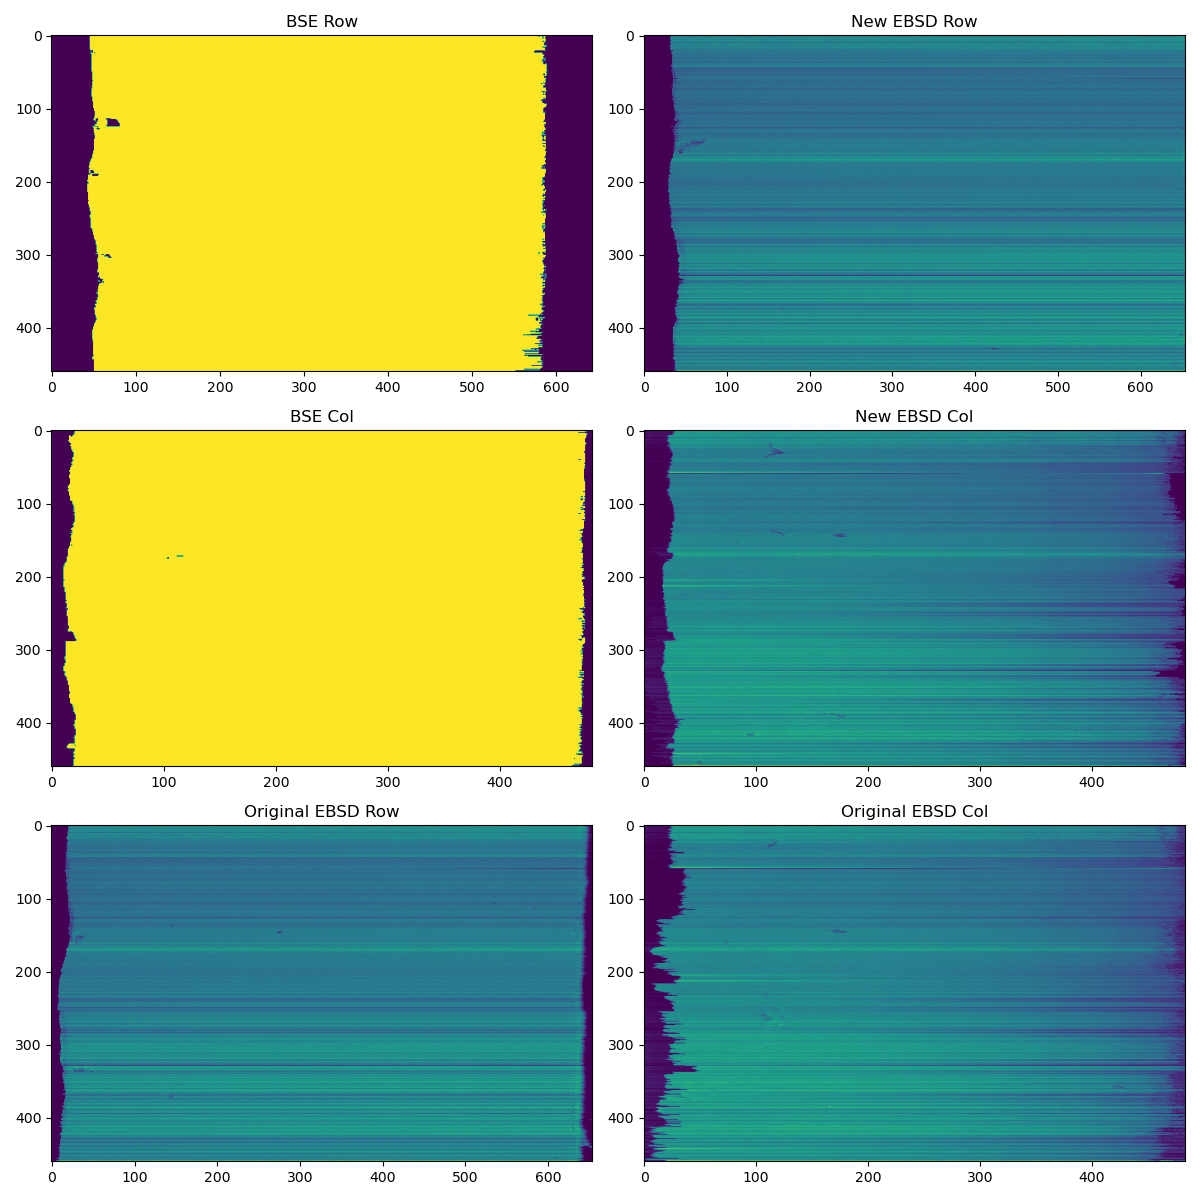

In [10]:
ebsd = h5[s+"SEM"][:,:,:,0]
# ebsd = h5[s+"Mask"][:,:,:,0]
ebsd_new = apply_shifts(diff_total, ebsd)
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(321)

ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(323)
ax4 = fig.add_subplot(324)
ax5 = fig.add_subplot(325)
ax6 = fig.add_subplot(326)
ax1.set_title("BSE Row")
ax1.imshow(mask_filled[:, y, :], aspect="auto")
ax2.set_title("New EBSD Row")
ax2.imshow(ebsd_new[:, y, :], aspect="auto")
ax3.set_title("BSE Col")
ax3.imshow(mask_filled[:, :, x[1]], aspect="auto")
ax4.set_title("New EBSD Col")
ax4.imshow(ebsd_new[:, :, x[0]], aspect="auto")
ax5.set_title("Original EBSD Row")
ax5.imshow(ebsd[:, y, :], aspect="auto")
ax6.set_title("Original EBSD Col")
ax6.imshow(ebsd[:, :, x[0]], aspect="auto")
plt.tight_layout()
plt.show()


### Propogate shifts and write to H5

In [8]:
for key in h5[s].keys():
    data = h5[s+key][...]
    for dim in range(data.shape[-1]):
        data[:,:,:,dim] = apply_shifts(diff_total, data[:,:,:,dim])
    h5[s+key][...] = data
    print(key)

CI
EulerAngles
IPFColor_001
IQH
IQS
Mask
MisColor_001
Phase_mask
Phases
Quats
SEM
Stereo Coords
X
XC
Y
Z


In [9]:
h5.close()
